<a href="https://colab.research.google.com/github/GrainSack/ML/blob/main/Basic_CV_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/annotations/annotations/list.txt' , skiprows = 6 ,delimiter = ' ', header = None)


In [ ]:
df.columns = [ 'file_name','id','species', 'breed']
df

,file_name,id,species,breed
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


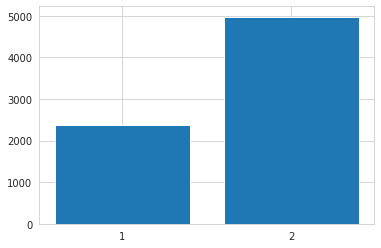

In [ ]:
value_counts = df['species'].value_counts().sort_index()
plt.bar(range(len(value_counts)),value_counts.values ,align = 'center')
plt.xticks(range(len(value_counts)),value_counts.index.values)

plt.show()

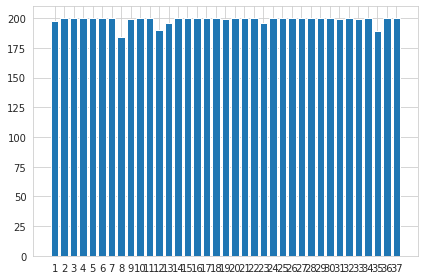

In [ ]:
#plt.figure(figsize = (12,8))
value_counts = df['id'].value_counts().sort_index()
plt.bar(range(len(value_counts)),value_counts.values ,align = 'center')
plt.xticks(range(len(value_counts)),value_counts.index.values)

plt.tight_layout()
plt.show()

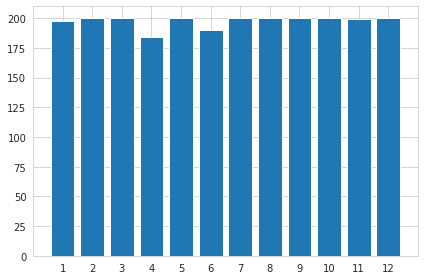

In [ ]:
#plt.figure(figsize = (12,8))
value_counts = df[df['species']==1]['breed'].value_counts().sort_index()
plt.bar(range(len(value_counts)),value_counts.values ,align = 'center')
plt.xticks(range(len(value_counts)),value_counts.index.values)

plt.tight_layout()
plt.show()

In [ ]:
import os
from glob import glob

In [ ]:
path = '/content/drive/MyDrive/annotations/annotations'
image_dir = '/content/drive/MyDrive/images/images/'
bbox_dir = path + '/xmls/'
seg_dir = path + '/trimaps/'

In [ ]:
image_files = glob(image_dir + '*.jpg')
len(image_files)

7390

In [ ]:
seg_files = glob(seg_dir + '*.png')
len(seg_files)

7390

In [ ]:
bbox_files = glob(bbox_dir + '*.xml')
len(bbox_files)

3686

In [ ]:
import cv2
import xml.etree.ElementTree as et
from matplotlib.patches import Rectangle

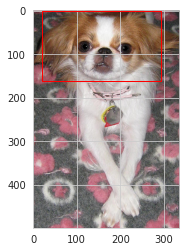

In [ ]:
image_path = image_files[89]
bbox_path = image_path.replace(image_dir,bbox_dir).replace('jpg','xml')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
tree = et.parse(bbox_path)

xmin = float(tree.find('./object/bndbox/xmin').text)
xmax = float(tree.find('./object/bndbox/xmax').text)
ymin = float(tree.find('./object/bndbox/ymin').text)
ymax = float(tree.find('./object/bndbox/ymax').text)

rect_x = xmin
rect_y = ymin
rect_w = xmax - xmin
rect_h = ymax - ymin

rect = Rectangle((rect_x,rect_y),rect_w,rect_h,fill=False, color = 'red')
plt.axes().add_patch(rect)
plt.imshow(image)

plt.show()

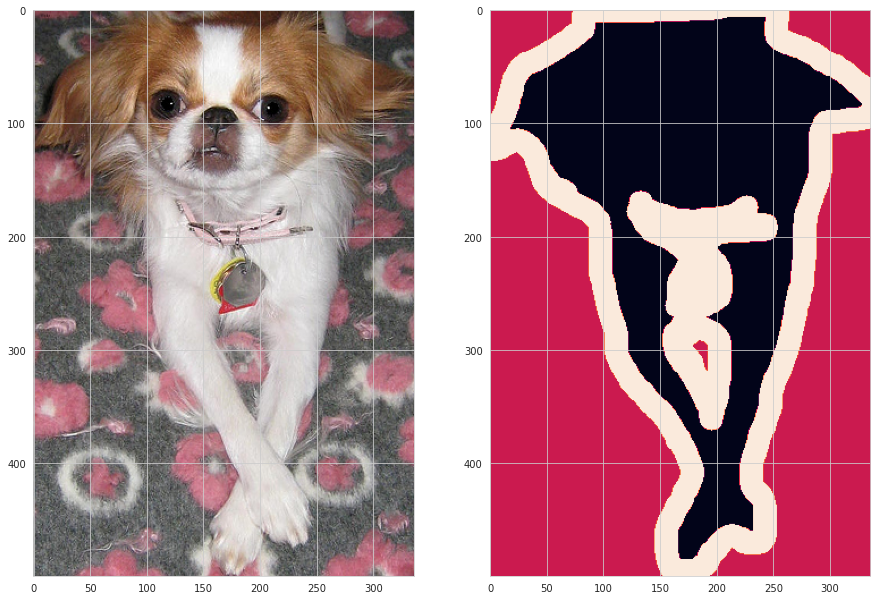

In [ ]:
image_path = image_files[89]
seg_path = image_path.replace(image_dir,seg_dir).replace('jpg','png')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
seg_map =cv2.imread(seg_path, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(seg_map)

plt.show()

##Split to K fold

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

df['fold'] = -1

for idx, (t,v) in enumerate (kf.split(df),1):
  print(idx)
  df.loc[v,'fold'] = idx

1
2
3
4
5


In [ ]:
print(len(df[df['fold']==1])) #해당 fold에 대한 검증 데이터
print(len(df[df['fold']!=1])) #해당 fold에 대한 test 데이터

1470
5879


In [ ]:
#각 fold 마다 class 에 uniform 하게 distributed 되어있는 split set 만들기
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
df['fold'] = -1

for idx, (t,v) in enumerate (skf.split(df,df['id']),1):
  df.loc[v,'fold'] = idx

In [ ]:
df.to_csv('/content/drive/MyDrive/k.folds.csv',index = False)

In [ ]:
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, batch_size, csv_path, fold,image_size, mode = 'train',shuffle = True):
    self.batch_size = batch_size
    self.image_size = image_size
    self.shuffle = shuffle
    self.fold = fold
    self.mode = mode

    self.df = pd.read_csv(csv_path)
    if self.mode =='train':
        self.df = self.df[self.df['fold']!=self.fold]
    elif self.mode =='val':
        self.df = self.df[df['fold']==self.fold]
    ##Remove invalid files
    invalid_filenames = [
        'Egyptian_Mau_14',
        'Egyptian_Mau_139',
        'Egyptian_Mau_145',
        'Egyptian_Mau_156',
        'Egyptian_Mau_167',
        'Egyptian_Mau_177',
        'Egyptian_Mau_186',
        'Egyptian_Mau_191',
        'Abyssinian_5',
        'Abyssinian_34',
        'chihuahua_121',
        'beagle_116'
    ]
    self.df = self.df[~self.df['file_name'].isin(invalid_filenames)]
    self.transform = Augmentation(image_size,mode)
    
    self.on_epoch_end()

  def __len__(self):
    return math.ceil(len(self.df)/self.batch_size)

  def __getitem__(self,idx):
    strt = idx * self.batch_size
    fin = (idx +1) * self.batch_size
    data = self.df.iloc[strt:fin]
    
    batch_x, batch_y = self.get_data(data)
    return np.array(batch_x) , np.array(batch_y)

  def get_data(self,data):
    batch_x = []
    batch_y = []
    for _,r in data.iterrows():
      file_name = r['file_name']
      image = cv2.imread(f'/content/drive/MyDrive/images/images/{file_name}.jpg')
      image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
      image = cv2.resize(image,(self.image_size,self.image_size))

      if self.mode == 'train':
        #uint8 일때만 되는 Agumentation method들이 있다
        image = image.astype('uint8')
        image = self.transform(image = image)

      image = image.astype('float32')
      image = image/255.

      label = int(r['species'])-1
      batch_x.append(image)
      batch_y.append(label)
    return batch_x, batch_y
    
  def on_epoch_end(self):
    if  self.shuffle:
      self.df = self.df.sample(frac = 1).reset_index(drop = True)

In [ ]:
csv_path = '/content/drive/MyDrive/kfolds.csv'
train_generator = DataGenerator(batch_size = 9, csv_path = csv_path,fold =1,image_size = 256)

In [ ]:
csv_path = '/content/drive/MyDrive/kfolds.csv'
train_generator = DataGenerator(
    fold = 1,
    mode = 'train',
    csv_path = csv_path,
    batch_size = 128,
    image_size = 256,
    shuffle = True
)
valid_generator = DataGenerator(
    fold = 1,
    mode = 'val',
    csv_path = csv_path,
    batch_size = 128,
    image_size = 256,
    shuffle = True
)

In [ ]:
print(len(train_generator))

46


In [ ]:
train_generator

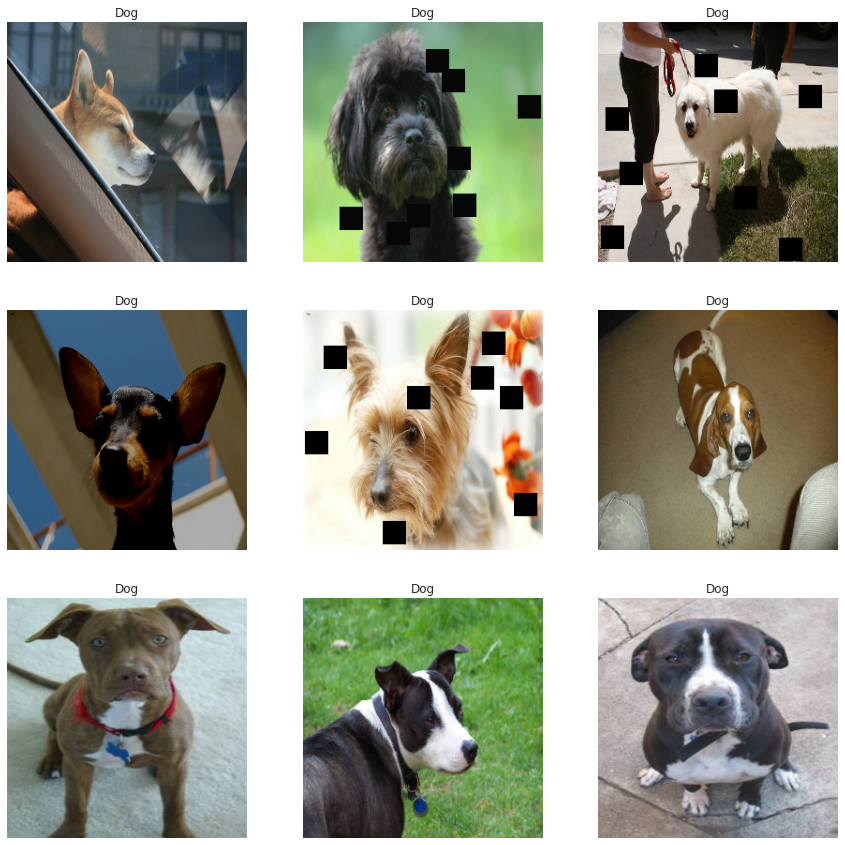

In [ ]:
class_name = ['Cat','Dog']

for batch in train_generator:
  X, y  = batch
  plt.figure(figsize = (15,15))
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(X[i])
    plt.title(class_name[y[i]])
    plt.axis('off')
  break

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [ ]:
def get_sequential_model(input_shape):
  model = keras.Sequential(
      [
          #input
          layers.Input(input_shape),
          #1st Conv block
          layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same'),
          layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same'),
          layers.MaxPool2D(),
          layers.BatchNormalization(),
          layers.Dropout(0.5),

          #2nd Conv block
          layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same'),
          layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same'),
          layers.MaxPool2D(),
          layers.BatchNormalization(),
          layers.Dropout(0.3),

          #Classifier
          layers.GlobalMaxPool2D(),
          layers.Dense(128, activation = 'relu'),
          layers.Dense(1,activation = 'sigmoid')
      ]
  )
  return model

input_shape = (256,256,3)
model = get_sequential_model(input_shape)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

#Using Functional api

In [ ]:
def get_functional_model(input_shape):
  #input
  inputs = keras.Input(input_shape)
  #1st Conv block
  x = layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same')(inputs)
  x = layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same')(x)
  x = layers.MaxPool2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  #2nd Conv block
  x = layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same')(x)
  x = layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same')(x)
  x = layers.MaxPool2D()(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.3)(x)

  #Classifier
  x = layers.GlobalMaxPool2D()(x)
  x = layers.Dense(128, activation = 'relu')(x)
  outputs = layers.Dense(1,activation = 'sigmoid')(x)

  model = keras.Model(inputs, outputs)

  return model

input_shape = (256,256,3)
model = get_functional_model(input_shape)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 128, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 64)      0     

#Model subclassing

In [ ]:
class SimpleCNN(keras.Model):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    self.conv_block_1 = keras.Sequential(
        [
            layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same'),
            layers.Conv2D(64,3,strides =1, activation = 'relu',padding ='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
        ], name = 'conv_block_1'
    )
    self.conv_block_2 = keras.Sequential(
        [
            #2nd Conv block
            layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same'),
            layers.Conv2D(128,3,strides =1, activation = 'relu',padding ='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        ],name = 'conv_block_2'
    )
    self.classifier = keras.Sequential(
        [
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation = 'relu'),
            layers.Dense(1,activation = 'sigmoid')            
        ],name = 'classifier'
    )
  def call(self, input_tensor, training = False):
    x = self.conv_block_1(input_tensor)
    x = self.conv_block_2(x)
    x = self.classifier(x)

    return x

In [ ]:
input_shape = (None, 256,256,3)
model = SimpleCNN()
model.build(input_shape)

model.summary()

Model: "simple_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_block_1 (Sequential)   (None, 128, 128, 64)      38976     
                                                                 
 conv_block_2 (Sequential)   (None, 64, 64, 128)       221952    
                                                                 
 classifier (Sequential)     (None, 1)                 16641     
                                                                 
Total params: 277,569
Trainable params: 277,185
Non-trainable params: 384
_________________________________________________________________


##Model compiling

In [ ]:
model.compile(optimizer = 'adam',loss = 'binary_crossentropy',metrics = 'accuracy')

In [ ]:
import tensorflow as tf

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'val_loss', patience = 3, verbose = 1,
    mode = 'min', restore_best_weights = False
)

In [ ]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',vactor = 0.1, patience = 10, verbose = 1,
    mode = 'min', min_lr = 0.001
)

In [ ]:
filepath = '{epoch : 02d}={val_loss :.2f}.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath,monitor = 'val_loss', verbose = 1, save_best_only=True,
    save_weights_only=False, mode = 'min'
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    callbacks = [
        early_stopping,a
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose = 1
)

Epoch 1/10
27/46 [================>.............] - ETA: 34:34 - loss: 1.2814 - accuracy: 0.6223

#Data Augmentation

In [ ]:
!pip install albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import albumentations as A
import cv2
#Declare an augmentation pipline
class Augmentation:
  def __init__(self, size, mode = 'train'):
    if mode == 'train':
        self.transform = A.Compose(
            [
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                  p = 0.5,
                  shift_limit = 0.05,
                  scale_limit = 0.05,
                  rotate_limit = 15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes = 8,
                    max_height = int(0.1 * size),
                    max_width  = int(0.1 * size),
                ),
                A.RandomBrightnessContrast(p=0.2),
            ]
        )
  def __call__(self,**kwargs):
    if self.transform:
      augmented = self.transform(**kwargs)
      img = augmented['image']
      return img

#Transfer learning

In [ ]:
import os
import math
import cv2
import numpy as np
import pandas as pd
from tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBLE_DEVICES']='3'

In [ ]:
def get_model(input_shape):
  inputs = keras.Input(input_shape)
  base_model = EfficientNetB0(
      inout_shape = input_shape,
      weights = 'imagenet',
      include_top = False,
      pooling = 'avg'
  )
  x = base_model(inputs)
  output = layers.Dense(1, activation ='sigmoid')(x)
  model = keras.Model(inputs,output)

  return model

input_shape = (256,256,3)
model_trans = get_model(input_shape)
adam = keras.optimizers.Adam(lr = 0.0001)
model.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)
model_trans.summary()

In [ ]:
history_trans = model_trans.fit(
    train_generator,
    validation_data = valid_generator,
    epochs = 10,
    verbose = 1
)

#TF Hub
https://tfhub.dev/

In [ ]:
import os
import math
import cv2
import numpy as np
import pandas as pd
import tensorflow as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

os.environ['CUDA_VISIBILE_DEVICES']='3'

In [ ]:
import tensorflow_hub as hub

model_hub = tf.keras.Sequential(
    [
        hub.KerasLayer(
            "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
            trainable = True),
        tf.keras.layer.Dense(1,activation = 'sigmoid')
        )
    ]
)
m.build([None,256,256,3]) #batch input shape.
adam = keras.optimizers.Adam(lr = 0.0001)
model_hub.compile(
    optimizer = adam,
    loss = 'binary_crossentropy',
    metrics = 'accuracy'
)
model_hub.summary()